In [1]:
import pprint
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from kmodes.kmodes import KModes
from yellowbrick.utils import KneeLocator

%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use("seaborn-colorblind")

In [2]:
def main():
    dataset_costs = {}
    for dataset_name in ("breast_cancer", "mushroom", "soybean", "nursery"):

        df = pd.read_csv(f"../data/{dataset_name}.csv", na_values=["?", "dna"])
        df = df.drop("class", axis=1).dropna()

        costs = []
        cluster_range = range(2, int(np.sqrt(len(df))) + 1)
        for k in tqdm.tqdm(cluster_range):
            km = KModes(n_clusters=k, init="cao", random_state=0).fit(df)
            costs.append(km.cost_)

        dataset_costs[dataset_name] = costs

        cost_df = pd.DataFrame(
            {"cost": costs, "min_nclusters": min(cluster_range), "max_nclusters": max(cluster_range)}
        )
        cost_df.to_csv(f"../data/elbow/{dataset_name}_costs.csv", index=False)

    return dataset_costs

In [3]:
# dataset_costs = main()

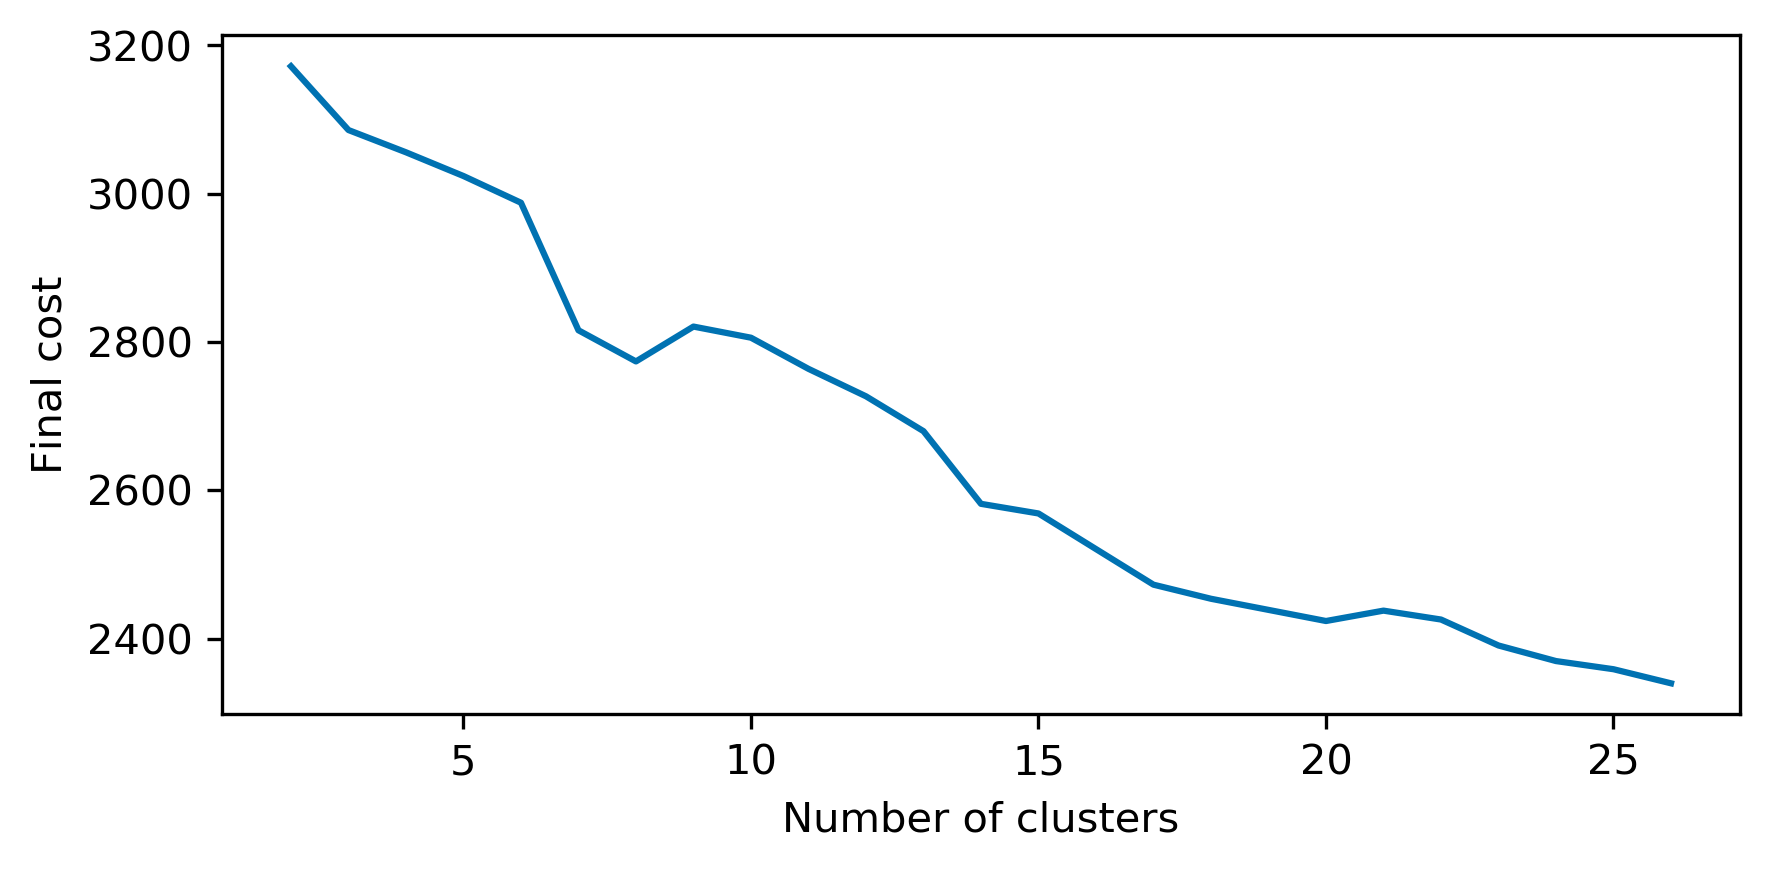

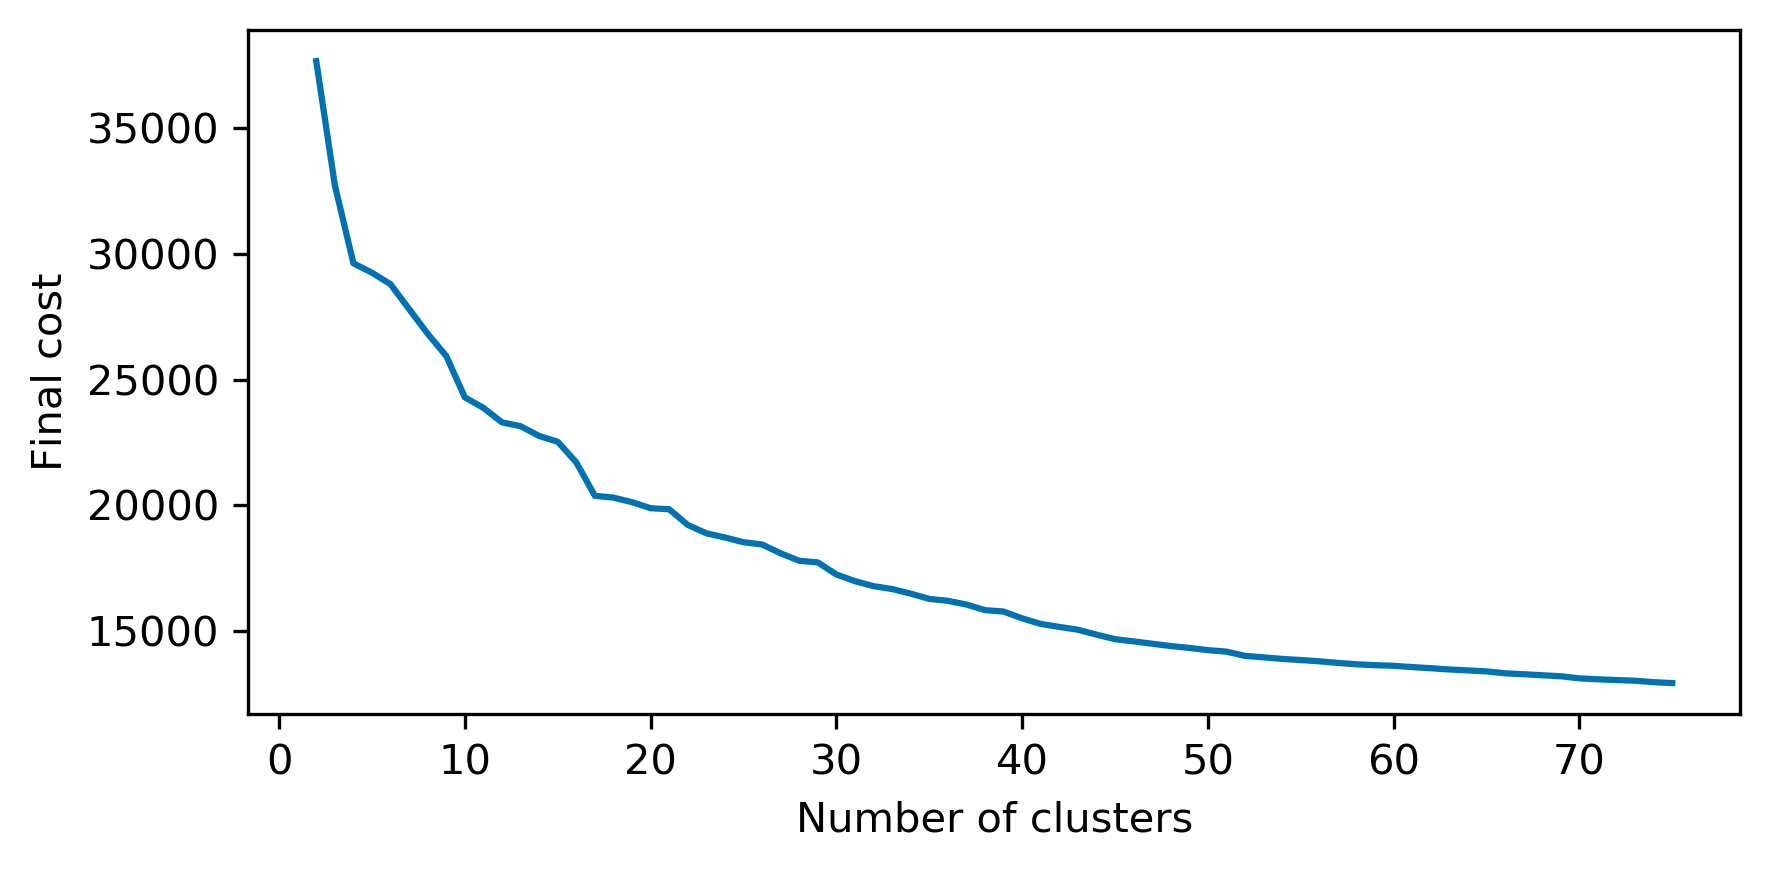

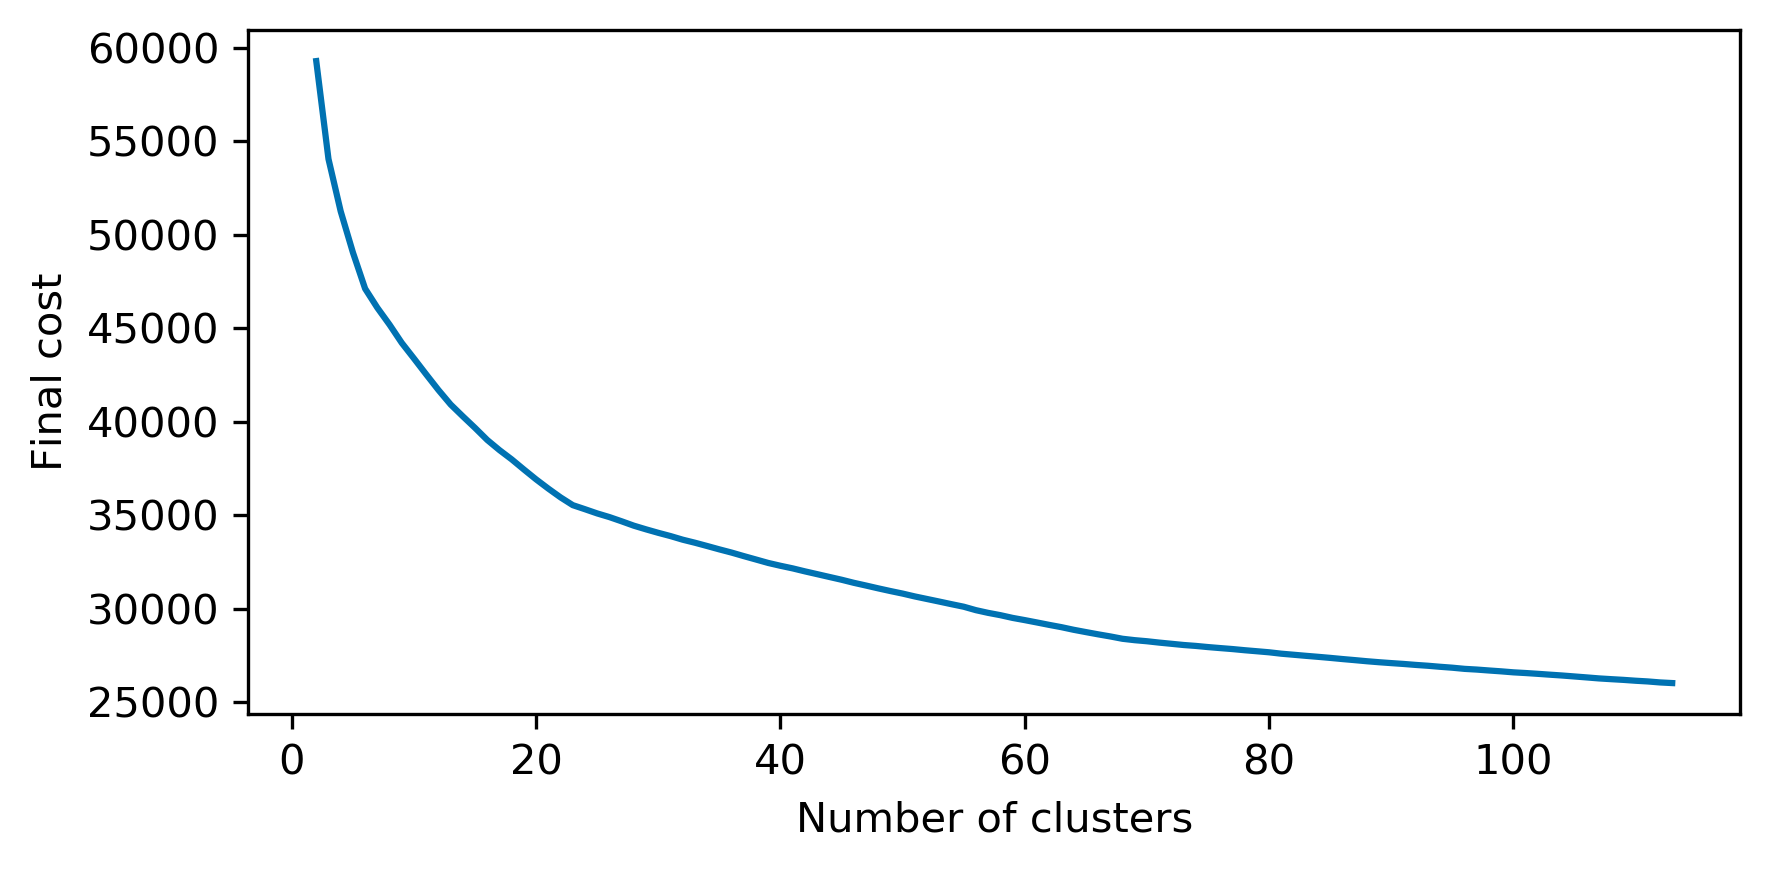

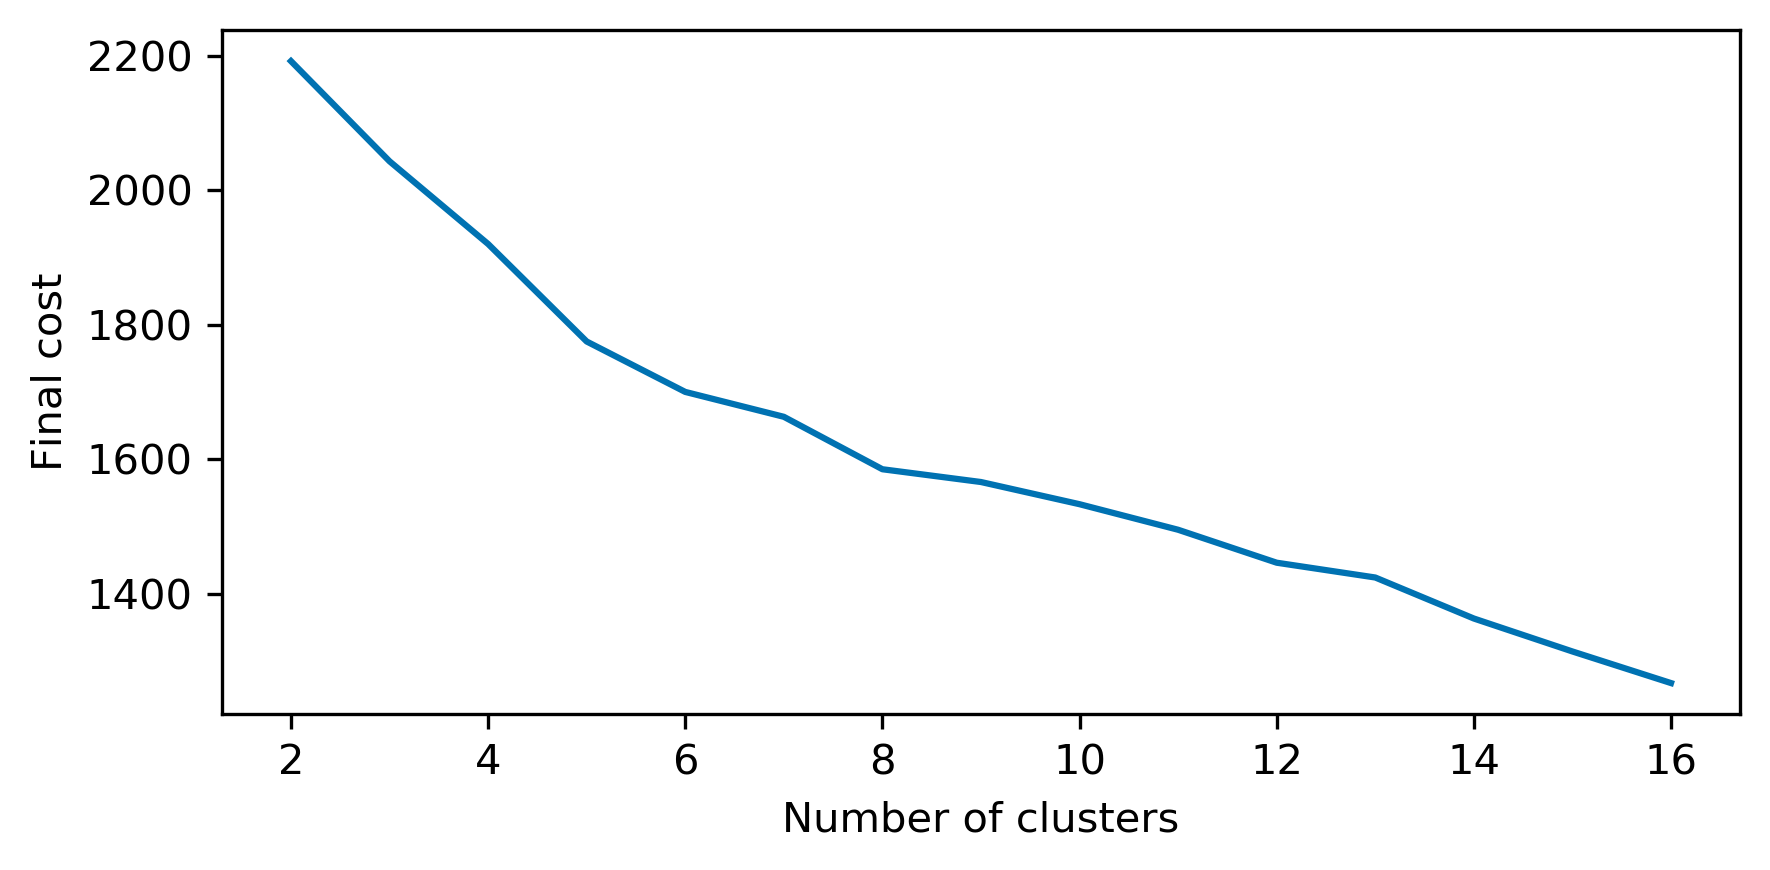

In [11]:
Summary = namedtuple(
    "Summary",
    [
        "name",
        "num_rows",
        "num_columns",
        "num_classes",
        "missing_values",
        "adjusted_num_rows",
        "adjusted_num_classes",
        "num_clusters_found",
    ],
)

summaries = []
for name in ("breast_cancer", "mushroom", "nursery", "soybean"):

    costs = pd.read_csv(f"../data/elbow/{name}_costs.csv")
    df = pd.read_csv(f"../data/{name}.csv", na_values=["?", "dna"])

    kl = KneeLocator(
        costs.index.values + 2, costs["cost"].values, curve_nature="convex", curve_direction="decreasing"
    )

    classes = df["class"]
    df = df.drop("class", axis=1)

    dropped_df = df.dropna()
    missing_values = len(dropped_df) != len(df)

    nrows, ncols = df.shape
    nclasses = classes.nunique()
    adjusted_nrows = len(dropped_df)
    adjusted_nclasses = classes.iloc[dropped_df.index].nunique()

    summaries.append(
        Summary(
            name,
            nrows,
            ncols,
            nclasses,
            missing_values,
            adjusted_nrows,
            adjusted_nclasses,
            kl.knee,
        )
    )

    fig, ax = plt.subplots(figsize=(6, 3), dpi=300)

    xs = costs.index.values + 2
    ax.plot(xs, costs["cost"])
#     ax.plot(
#         [min(xs), max(xs)], [costs["cost"].max(), costs["cost"].min()], color="gray"
#     )

    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Final cost")
    
    plt.tight_layout()
    plt.savefig(f"../img/elbow/{name}_costs.pdf", transparent=True)


In [12]:
summary_df = pd.DataFrame(summaries).set_index("name")
summary_df.index = [" ".join(name.split("_")).capitalize() for name in summary_df.index]
summary_df.columns = [
    " ".join(col.replace("num", "no.").split("_")).capitalize()
    for col in summary_df.columns
]

summary_df.to_latex("../tex/dataset_summary.tex")
summary_df

,No. rows,No. columns,No. classes,Missing values,Adjusted no. rows,Adjusted no. classes,No. clusters found
Breast cancer,699,10,2,True,683,2,8
Mushroom,8124,22,2,True,5644,2,17
Nursery,12960,8,5,False,12960,5,23
Soybean,307,35,19,True,266,15,8
